In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model import *
from pickle_cache import PickleCache
import pandas as pd
from experiment_widgets import VariableTracingExperiment
import json
from random import sample, randint, choices
import string
import matplotlib.pyplot as plt 
from tqdm.auto import tqdm
import seaborn as sns
import torch.distributions.constraints as constraints

sns.set()

pcache = PickleCache()

In [3]:
all_names = string.ascii_lowercase
all_operators = ['+', '-']

def generate_trial(N):
    names = sample(all_names, k=N)
    variables = [
        {'variable': names[i], 'value': randint(1, 9)}
        for i in range(N)
    ]

    expr_var_order = sample(variables, k=len(variables))
    operators = choices(all_operators, k=N-1)
    expr_list = []
    expr_value = expr_var_order[0]['value']
    for i in range(N):
        if i > 0:
            op = operators[i-1]
            expr_value = eval(f"{expr_value} {op} {expr_var_order[i]['value']}")
            expr_list.append(op)
        expr_list.append(expr_var_order[i]['variable'])
    expr = ' '.join(expr_list)
    
    return {
        'variables': variables, 
        'expression': expr,
        'expression_value': expr_value
    }

def exp_name(N_var, N_trials):
    return f'vartrace_{N_var}_{N_trials}'

In [4]:
N_var = 7
N_trials = 10

experiment = {
    'trials': [generate_trial(N_var) for _ in range(N_trials)],
    'between_trials_time': 1000
}

exp = VariableTracingExperiment(experiment=json.dumps(experiment), results='[]')

def on_result_change(_):
    pcache.set(exp_name(N_var, N_trials), {
        'experiment': experiment,
        'results': json.loads(exp.results)
    })
    
#exp.observe(on_result_change)

exp

VariableTracingExperiment(experiment='{"trials": [{"variables": [{"variable": "p", "value": 8}, {"variable": "…

In [5]:
def process_results(N_var, N_trials):
    data = pcache.get(exp_name(N_var, N_trials))
    experiment = data['experiment']
    results = data['results']
    
    df = []
    for (trial, result) in zip(experiment['trials'], results):
        try:
            response = int(result['response'])
        except ValueError:
            response = -1000
                   
        correct = trial['expression_value'] == response
        df.append({
            'N_var': N_var,
            'correct': correct,
            'switches': result['switch_count']//2,
            'response_time': result['response_time']/1000.
        })
    return pd.DataFrame(df)

process_results(N_var, N_trials)

,N_var,correct,switches,response_time
0,7,True,3,25.240
1,7,True,1,20.318
2,7,False,2,18.790
3,7,True,3,24.138
4,7,True,2,26.821
5,7,True,1,13.549
6,7,True,1,15.813
7,7,True,1,11.606
8,7,True,3,35.147
9,7,True,1,18.842


In [6]:
all_exp = [2, 3, 4, 5, 6, 7]
results = pd.concat([process_results(N_var, 10) for N_var in all_exp])

Text(0, 0.5, 'Response time (s)')

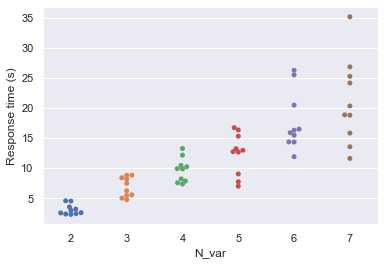

In [7]:
ax = sns.swarmplot(data=results, x='N_var', y='response_time')
ax.set_ylabel('Response time (s)')

In [8]:
import statsmodels.formula.api as smf
data = results.groupby('N_var').response_time.nlargest(2).reset_index().groupby('N_var').mean().reset_index()
#smf.ols('response_time ~ np.power(N_var,2)', data=data).fit().summary()

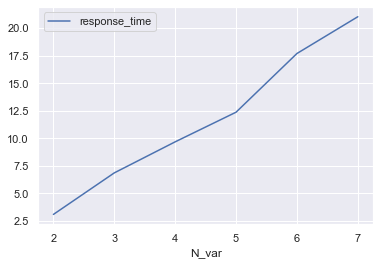

In [9]:
results.groupby('N_var').mean().plot(y='response_time')

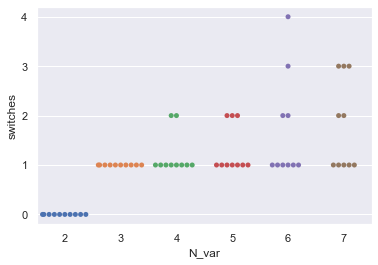

In [10]:

ax = sns.swarmplot(data=results, x='N_var', y='switches')
ax.set_yticks(list(range(5)))

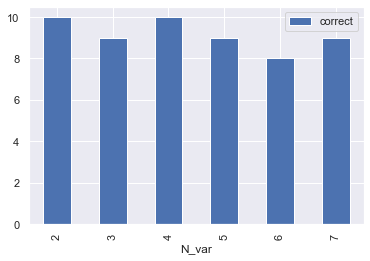

In [11]:
results.groupby('N_var').sum().plot.bar(y='correct')

In [12]:
#     params = {
#     name: {
#         'mu': pyro.param(f'{name}_mu', tensor(init_mu)),
#         'sigma': pyro.param(f'{name}_sigma', tensor(init_sigma))
#     }   
#     for name, (init_mu, init_sigma) in params.items()
# }


In [13]:
# params = {
#     'number_cost': (1.0, 0.01),
#     'var_cost': (0.1, 0.01),
#     'binop_cost': (2.5, 0.2),
#     'assign_cost': (0.1, 0.01)
# }

params = {
    'number_cost': (0.5, 0.5),
    'var_cost': (0.5, 0.5),
    'binop_cost': (2.0, 1.0),
    'assign_cost': (0.5, 0.5)
}

def _model(trial, param_values):
    wm = WorkingMemory()
    src = [
        f"{v['variable']} = {v['value']}"
        for v in trial['variables']
    ] + [trial['expression']]
    prog = parse('\n'.join(src))

    visitor = TraceVisitor(wm=wm, ctx=prog.statements[:-1], params=param_values)
    visitor.visit(prog.statements[-1])
    
    ret = pyro.sample('response_time', dist.Normal(visitor.time, 1.0))
    reset_name_counters()
    return ret

def model(trial):
    param_values = {
        name: {
            'mu': tensor(init_mu),
            'sigma': tensor(init_sigma)
        }
        for name, (init_mu, init_sigma) in params.items()
    }
    return _model(trial, param_values)

def guide(trial):
    param_values = {
        name: {
            'mu': pyro.param(f'{name}_mu', tensor(init_mu)),
            'sigma': pyro.param(f'{name}_sigma', tensor(init_sigma), constraint=constraints.positive)
        }
        for name, (init_mu, init_sigma) in params.items()
    }
    return _model(trial, param_values)

In [14]:
data = pcache.get(exp_name(N_var, N_trials))
experiment = data['experiment']
#results = data['results']
trials = experiment['trials']

def obs_model(i):
    return pyro.condition(model, data={
        'response_time': tensor(data['results'][i]['response_time']/1000.)})(trials[i])

In [15]:
from pyro.poutine import trace
t = trace(obs_model).get_trace(0)
#sorted(list(t.nodes.keys()))
t.log_prob_sum()

tensor(860.7120)

In [28]:
from pyro.infer import SVI, ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDelta
pyro.clear_param_store()

class Loss(ELBO):
    def loss(self, model, guide):
        
svi = SVI(obs_model, lambda i: guide(trials[i]), Adam({'lr': 1.0}), loss=Trace_ELBO())
loss_over_time = []
for i in tqdm(range(300)):
    loss = []
    for j in range(len(trials)):
        loss.append(svi.step(j))
        
    loss_over_time.append(pd.Series(loss).median())
    
    if i % 10 == 0:
        print(loss_over_time[-1])

IndentationError: expected an indented block (<ipython-input-28-ea679863a6cb>, line 8)

In [17]:
params

{'number_cost': (0.5, 0.5),
 'var_cost': (0.5, 0.5),
 'binop_cost': (2.0, 1.0),
 'assign_cost': (0.5, 0.5)}

In [18]:
{
    name: {
        'mu': pyro.param(f'{name}_mu', tensor(init_mu)).item(),
        'sigma': pyro.param(f'{name}_sigma', tensor(init_sigma)).item()
    }
    for name, (init_mu, init_sigma) in params.items()
}

{'number_cost': {'mu': 0.35697755217552185, 'sigma': 0.22034183144569397},
 'var_cost': {'mu': 0.08643551915884018, 'sigma': 0.33893024921417236},
 'binop_cost': {'mu': 0.9074722528457642, 'sigma': 0.33093294501304626},
 'assign_cost': {'mu': 0.11931444704532623, 'sigma': 0.3331072926521301}}

In [19]:
# from pyro.infer import MCMC, NUTS
# nuts = NUTS(obs_model)
# mcmc = MCMC(nuts, num_samples=500, warmup_steps=100).run(0)
# mcmc.run()

In [20]:
def simulate_many(model):
    return pd.DataFrame([
        {'N_var': N_var, 'response_time': model(generate_trial(N_var)).item()}
        for N_var in tqdm(range(2, 8))
        for _ in range(200)
    ])

def stats(results, prefix):
    group = results.groupby('N_var')    
    return pd.DataFrame({
        f'{prefix}_median': group.median().response_time,
        f'{prefix}_mean': group.mean().response_time,
        f'{prefix}_std': group.std().response_time
    })

def show_results(results_sim):
    print(stats(results, 'actual'))
    print(stats(results_sim, 'sim'))
    ax = sns.boxplot(data=results_sim, x='N_var', y='response_time')
    ax.set_ylabel('Response time (s)')


       actual_median  actual_mean  actual_std
N_var                                        
2             2.7690       3.1004    0.856344
3             6.8465       6.8672    1.633656
4             9.8850       9.6823    1.981255
5            12.8400      12.3691    3.436759
6            16.0865      17.6909    4.822709
7            19.5800      21.0264    7.012014
       sim_median   sim_mean    sim_std
N_var                                  
2        6.622843   6.668116   2.050813
3       11.071151  11.622802   3.370313
4       15.938436  17.631330   6.479887
5       20.777253  24.260350  10.274637
6       26.413540  31.346066  13.665385
7       31.191304  38.983996  18.687033


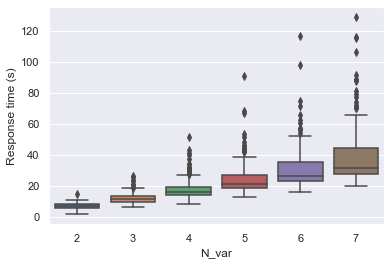

In [21]:
show_results(simulate_many(model))


       actual_median  actual_mean  actual_std
N_var                                        
2             2.7690       3.1004    0.856344
3             6.8465       6.8672    1.633656
4             9.8850       9.6823    1.981255
5            12.8400      12.3691    3.436759
6            16.0865      17.6909    4.822709
7            19.5800      21.0264    7.012014
       sim_median   sim_mean   sim_std
N_var                                 
2        2.975122   2.911501  1.262706
3        4.960077   5.291601  1.892244
4        7.300668   8.262322  3.540583
5        9.479843  10.594427  4.329399
6       12.144700  14.159629  5.865160
7       14.155668  17.445018  8.317524


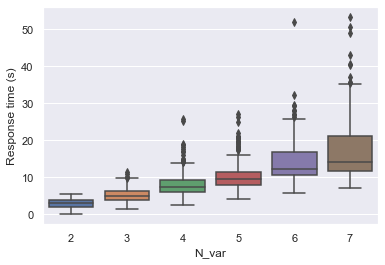

In [22]:
show_results(simulate_many(guide))

Text(0, 0.5, 'Response time (s)')

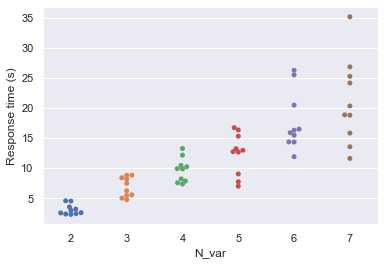

In [23]:
ax = sns.swarmplot(data=results, x='N_var', y='response_time')
ax.set_ylabel('Response time (s)')